In [3]:
# !wget https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV.json.gz  

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# !cp -r /content/drive/reviews_Movies_and_TV.json.gz /content/drive/MyDrive/reviews_Movies_and_TV.json.gz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!cp -r  /content/drive/MyDrive/reviews_Movies_and_TV.json.gz /content/reviews_Movies_and_TV.json.gz
!gzip -d /content/reviews_Movies_and_TV.json.gz

cp: cannot stat '/content/drive/MyDrive/reviews_Movies_and_TV.json.gz': No such file or directory
gzip: /content/reviews_Movies_and_TV.json.gz: No such file or directory


In [6]:
## imports 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import random
import json
import regex as re
import pprint
from collections import defaultdict
import sys
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import gensim.downloader as api
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
def special_cases(wiki):
    wiki=wiki.lower()
    wiki=re.sub("_"," ",wiki)
    wiki=re.sub(r'"',"",wiki)
    # wiki = re.sub(r'\s+\'bout', r' about', wiki)
    wiki=re.sub(r"won\'t","will not",wiki)
    wiki=re.sub(r"can\'t","cannot",wiki)
    wiki = re.sub(r'([a-zA-Z]+)n\'t', r'\1 not', wiki)
    wiki = re.sub(r'([a-zA-Z]+)\'s', r'\1 is', wiki)
    wiki = re.sub(r'([a-zA-Z]+)\'re', r'\1 are', wiki)
    wiki = re.sub(r'([a-zA-Z]+)\'ll', r'\1 will', wiki)
    wiki = re.sub(r'([a-zA-Z]+)\'d', r'\1 would', wiki)
    wiki = re.sub(r'([a-zA-Z]+)\'ve', r'\1 have', wiki)
    wiki = re.sub(r'([iI])\'m', r'\1 am', wiki)

    return wiki

def tokenizer(wiki):
    wiki=re.sub(r' [0-9]+ '," <NUM> ",wiki)
    wiki=re.sub(r' [0-9]+ '," <NUM> ",wiki)
    wiki = re.sub(r'[^\x00-\x7F]+', ' ', wiki)
    prefix=['@','#']
    # for sep in string.
    wiki = re.sub(r"@[A-Za-z0-9_]+", "<MENTION>", wiki) # mention
    wiki = re.sub(r"#[A-Za-z0-9_]+", "<HASHTAG>", wiki) # hashtag
    wiki = re.sub(r'(https?:\/\/|www\.)?\S+[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\S+', ' <URL> ', wiki)  #url
    # wiki = re.sub(r'(?<=\s)[\:\.]?\d*[\:\.]?\d*[\:\.]?(?=\s)', ' <NUM> ', wiki) # Number
    # wiki=  re.sub(r'\w*(!|"|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|\/|:|;|<|=|>|\?|\[|\\|\]|\^|\{|\||\}|~)\1{1,}', r' ', wiki)
    return wiki

def remove_stupid_fullstop(wiki):
    wiki=re.sub("Mr\s*.","Mr",wiki)
    wiki=re.sub("Ms\s*.","Ms",wiki)
    wiki=re.sub("Mrs\s*.","Mrs",wiki)
    wiki=re.sub("Miss\s*.","Miss",wiki)

    return wiki

def detect_full_stop(data):
    # data = re.sub(r'!+', "!", data)
    # data = re.sub(r'\?+', "?", data)
    data = re.sub(r'[^\w+^\.^\?^\!\s]', r' ', data)
    data=re.sub(r'(\.+)|(\?+)|(!+)'," ",data)
    return data
  
def basic_stuff(data):
  
  data=data.strip()
  data=re.sub(" +"," ",data)
  return data

def tokenise(wiki):
    # with open(path,"r") as fp:
    #     wiki=fp.readlines()
    # wiki="\n".join(wiki)
    # wiki=re.sub("\n+"," ",wiki)
    wiki=basic_stuff(wiki)
    wiki=remove_stupid_fullstop(wiki)
    wiki=special_cases(wiki)
    wiki=detect_full_stop(wiki)
    wiki=tokenizer(wiki)
    wiki=basic_stuff(wiki)
    return wiki


In [8]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

def read(path,limit):
  data=pd.read_json(path,lines=True,chunksize=10000)
  total_sentences=0
  list_appender=[]
  
  for id,x in enumerate(data):

    val=x["reviewText"]
    for collect in val:
      collect=remove_stupid_fullstop(collect)
      sent_list=collect.split(".")
      sent_list = list(filter(None, sent_list))
      final_list=[]
      for sentence in sent_list:
        cleared_sentence=tokenise(sentence)
        final_list.append(cleared_sentence)
      total_sentences+=len(final_list)
      list_appender=list_appender+final_list
      if(total_sentences>limit):
        return list_appender
      
def unk_builder(sent_list,cap):
  print(cap)
  word_dict=dict()
  for sentence in sent_list:
    word_list=re.split(" ",sentence)
    word_list = list(filter(None, word_list))
    for word in word_list:
      if word in word_dict:
        word_dict[word]+=1
      else:
        word_dict[word]=1
  word_dict["<UNK>"]=1
  new_list=[]
  for sentence in sent_list:
    word_list=re.split(" ",sentence)
    word_list = list(filter(None, word_list))
    word_list.insert(0,"<START>");word_list.append("<END>")
    new_word_list=[]
    for word in word_list:
      if word in word_dict:
        if cap>=word_dict[word]:
          new_word_list.append("<UNK>")
          del word_dict[word]
        else:
          new_word_list.append(word)
      else:
        new_word_list.append("<UNK>")
    new_list.append(" ".join(new_word_list))

  return new_list,word_dict

def pad_sentences(sent_list):
  # [print(seq.split(" ")) for seq in sent_list]
  maxlen=max([len(list(filter(None,seq.split(" ")))) for seq in sent_list])
  for i,sentence in enumerate(sent_list):
    sent_l=len(sentence.split(" "))
    pad_n=maxlen-sent_l
    pad_str=""
    for _ in range(pad_n):
      pad_str+="<PAD> "
    
    sent_list[i]=pad_str+sent_list[i]
  return sent_list,maxlen

def final_prep(path,num_of_sent,cap):
  
  sent_list=read(path,num_of_sent)
  sent_list,word_dict=unk_builder(sent_list,cap)
  # sent_list,maxlen=pad_sentences(sent_list)
  word_dict["<PAD>"]=0;word_dict["<START>"]=cap*2+1;word_dict["<END>"]=cap*2+1
  return sent_list,word_dict
    

sent_list,word_dict=final_prep("/content/reviews_Movies_and_TV.json",44000,2)

2


In [9]:
def dict_index_builder(word_dict):
  new_dict={key:i for i,key in enumerate(word_dict.keys())}
  inv_map = {v: k for k, v in new_dict.items()}

  return new_dict,inv_map
index_dict,reverse_index_dict=dict_index_builder(word_dict)

In [10]:
print(len(index_dict))
vocab_size=len(index_dict)
PAD_VAL=index_dict["<PAD>"]
PAD_TOKEN="<PAD>"



9995


# SVD

In [11]:
scaler = StandardScaler()

def svd(sent_list,window_size,num_words,embedding_dim=50):
  start_str="";end_str=""
  data=[]
  # for i in range(window_size):
  #   start_str+="<START> "
  #   end_str+=" <END>"
  cooc_mat = np.zeros((num_words, num_words), dtype=np.int32)
  for sentence in sent_list:
    sent=sentence
    sent=start_str+sent+end_str
    sent=list(filter(None,sent.split(" ")))
    
    # for i in range(window_size,len(sent)-window_size+1):
    #   word=sent[i]
    #   for j in range(i-window_size,i+window_size):
    #     if(i==j):
    #       continue
    #     cooc_mat[index_dict[sent[j]],index_dict[word]]+=1
    for i in range(1,len(sent)-1):
      word=sent[i]
      l=max(0,i-window_size)
      r=min(len(sent),i+window_size)
      word_arr=sent[l:i]+sent[i:r]
      if(len(word_arr)<2*window_size):
        if((i-l)<window_size):
          for _ in range(window_size-(i-l)):
            word_arr.insert(0,"<PAD>")
        else:
          for _ in range(window_size-(r-i)):
            word_arr.append("<PAD>")
      
      if(len(word_arr)!=2*window_size):
        print(len(word_arr))
      for w in (word_arr):
        cooc_mat[index_dict[w],index_dict[word]]+=1
  print("SVD")
  svd_inst = TruncatedSVD(n_components=embedding_dim, n_iter=10)
  word_embeddings = svd_inst.fit_transform(cooc_mat)
  return scaler.fit_transform(word_embeddings)


svd_embeds=svd(sent_list,2,vocab_size)


SVD


In [12]:
# print(type(svd_embeds))
# with open('/content/drive/MyDrive/svd.npy', 'wb') as f:
#     np.save(f, svd_embeds, allow_pickle=True)

In [13]:
from sklearn.neighbors import NearestNeighbors
def nearest_words(embeddings,word,top=10):
  knn=NearestNeighbors(metric='cosine')
  knn.fit(embeddings)
  embedding_of_word=embeddings[index_dict[word]]
  _,val=knn.kneighbors(embedding_of_word.reshape(1,-1),n_neighbors=top+1)
  closest_words = []
  indices=val.flatten()[1:]
  for i in indices:
        closest_words.append(reverse_index_dict[i])
  return indices,closest_words

In [14]:
_,predictions_svd=nearest_words(svd_embeds,"titanic",10)
print(predictions_svd)


['inducing', 'cheek', 'objects', 'wisely', 'identification', 'wholesale', 'mulligan', 'soften', 'histories', 'docudrama']


#WORD2VEC

## dataset creation

In [15]:
# CBOW
cbow_dataset=[]
index_dict_list=list(index_dict.items())

def cbow_data(sent_list,window_size=2):
  start_str="";end_str=""
  data=[]
  for i in range(window_size):
    start_str+="<PAD> "
    end_str+=" <PAD>"
  for sentence in sent_list:
    sent=sentence
    sent=sent
    
    sent=list(filter(None,sent.split(" ")))
    for i in range(1,len(sent)-1):
      word=sent[i]
      outside_idxs=[]
      l=max(0,i-window_size)
      r=min(len(sent),i+window_size)
      word_arr=sent[l:i]+sent[i:r]
      if(len(word_arr)<2*window_size):
        if((i-l)<window_size):
          for _ in range(window_size-(i-l)):
            word_arr.insert(0,"<PAD>")
        else:
          for _ in range(window_size-(r-i)):
            word_arr.append("<PAD>")
      
      if(len(word_arr)!=2*window_size):
        print(len(word_arr))
      for w in (word_arr):
        outside_idxs.append(index_dict[w])
        
    # for i in range(window_size,len(sent)-window_size):
    #   word=sent[i]
    #   outside_idxs=[]
    #   word_arr=[]
    #   for j in range(i-window_size,i+window_size+1):
    #       if(i==j):
    #         continue
    #     # try:
    #       outside_idxs.append(index_dict[sent[j]])
    #       word_arr.append(sent[j])

      data.append((outside_idxs,index_dict[sent[i]],1))
      neg_idxs=[]
      for _ in range(4):

        neg_word, _ = random.choice(index_dict_list)
        # print(neg_word)
        while neg_word  in word_arr:
          neg_word,_=random.choice(index_dict_list)

        neg_idxs.append(index_dict[neg_word])
      data.append((neg_idxs,index_dict[sent[i]],0))
  


  print(len(data))
  targets=[]
  for ind,i in enumerate(data):
    targets.append(torch.tensor(i[2]).to(device).long())
    if(ind%100000==0):
      print(ind)
    data[ind]=(torch.tensor(i[0]).to(device).long(),torch.tensor(i[1]).to(device).long())
  return data,targets
cbow_dataset,cbow_targets=cbow_data(sent_list,2)


1565772
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000


## models

In [16]:

 
def myLoss(prediction,target):
  loss=torch.abs(prediction-target)
  # print(loss)
  mean_loss=torch.mean(loss,0).mean()
  # print(type(mean_loss[0]))
  return mean_loss

      


In [17]:
import torch.optim as optim

class cbow_model_linear(nn.Module):

  def __init__(self, embed_size, h1,h2,window_size=2):

      super(cbow_model_linear, self).__init__()

      self.e1=nn.Embedding(vocab_size,embed_size)
      self.l1=nn.Linear(5*embed_size,h2)
      self.l2=nn.Linear(h2,32)
      self.l3=nn.Linear(32,h1)
      self.sigmoid=nn.Sigmoid()
      nn.init.uniform_(self.e1.weight, -1.0, 1.0)


  def forward(self,input,output):

    e1=self.e1(output).unsqueeze(dim=1)
    i1=self.e1(input)
    new_embed=torch.concat((i1,e1),1)
    new_embed=torch.flatten(new_embed,start_dim=1)
    new_embed=new_embed.float()
    l1=F.leaky_relu(self.l1(new_embed))
    l2=F.leaky_relu(self.l2(l1))
    probs=self.l3(l2)

    return self.sigmoid(probs)


    
    
def train_cbow_linear(tensors,targets,embed_size,h1=1,h2=128,window_size=2,lr=1e-4,batch_size=64,epochs=1):
  model=cbow_model_linear(embed_size,h1,h2).to(device)
  optimiser=optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
  train_loader=DataLoader(tensors,batch_size=batch_size)
  target_loader=DataLoader(targets,batch_size=batch_size)
  criterion=nn.BCELoss().to(device)

  for epoch in tqdm(range(epochs),desc="Epoch"):
    model.train()
    loss_t=0

    for data,target in zip(train_loader,target_loader):

      optimiser.zero_grad()
      
      before=data[0].to(device)
      weight=data[1].to(device)
      prediction=model(before,weight).flatten()
      loss_iter=criterion(prediction,target.float())
      loss_t+=loss_iter.item()

      loss_iter.backward()
      optimiser.step()
    print(f'Epoch: ',epoch+1,'\n Loss: ',loss_t/len(train_loader))

  return model
cbow_model_linear_=train_cbow_linear(cbow_dataset,cbow_targets,128)



Epoch: 100%|██████████| 1/1 [01:11<00:00, 71.88s/it]

Epoch:  1 
 Loss:  0.03475081218099173


In [18]:
class cbow_model(nn.Module):

  def __init__(self, embed_size, h1):
      super(cbow_model, self).__init__()

      self.e1=nn.Embedding(vocab_size,embed_size)
      self.l1=nn.Linear(embed_size,h1)
      self.e2=nn.Embedding(h1,embed_size)
      nn.init.uniform_(self.e1.weight, -1.0, 1.0)


  def forward_pass(self,input):
    e1=self.e1(input).sum(dim=1)
    return e1

  def forward(self,input,output):
    e1=self.e1(output)
    i1=self.forward_pass(input)
    score=torch.mm(i1,torch.t(e1))
    probs=F.logsigmoid(score)
    return probs

    
def train_cbow(tensors,targets,embed_size,h1=512,h2=256,window_size=2,lr=1e-4,batch_size=64,epochs=1):
  model=cbow_model(embed_size,h1).to(device)
  optimiser=optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
  train_loader=DataLoader(tensors,batch_size=batch_size)
  target_loader=DataLoader(targets,batch_size=batch_size)
  criterion=nn.NLLLoss().to(device)

  for epoch in tqdm(range(epochs),desc="Epoch"):
    model.train()
    loss_t=0

    for data,target in zip(train_loader,target_loader):
      optimiser.zero_grad()
      # before, w = map(lambda x:x.to(torch.int64), data)
      before=data[0].to(device)
      weight=data[1].to(device)
      prediction=model(before,weight.to(torch.int64))
      loss_iter=criterion(prediction,target)
      loss_t+=loss_iter.item()

      loss_iter.backward()
      optimiser.step()
    print(f'Epoch: ',epoch+1,'\n Loss: ',loss_t/len(train_loader))

  return model

cbow_model_=train_cbow(cbow_dataset,cbow_targets,128)




Epoch: 100%|██████████| 1/1 [00:31<00:00, 31.06s/it]

Epoch:  1 
 Loss:  1.8724671052250368


## analysis

In [19]:
_,x=nearest_words(cbow_model_linear_.e1.weight.data.cpu().detach().numpy(),"titanic")
print(x)

['payback', 'advocates', 'additions', 'caveizel', 'blades', 'symbolically', 'keenan', 'jose', 'conflict', 'unbelievers']


In [20]:
_,x=nearest_words(cbow_model_.e1.weight.data.cpu().detach().numpy(),"titanic")
print(x)

['standards', 'journeys', 'chri', 'bloodlust', 'price', 'didnt', 'willing', 'buddha', 'priest', 'trusted']


In [21]:
# torch.save(cbow_model_linear.state_dict(),"cbow_model_linear.pth")

# TSNE

In [23]:
from sklearn.manifold import TSNE


In [66]:
test_arr=["titanic","great","lyricism","beauty","king"]
test_to_word_idx=[index_dict[w] for w in test_arr]

def plot_tsne(model,word_arr,num=10,svd=False):
  try:
    model_embedding=model.e1.weight.data.cpu().detach().numpy()
  except:
    model_embedding=model
  word_indices=[]
  word_actual=[]
  embeddings=[]
  colors = ['r', 'g', 'b', 'c', 'm']
  for ind,word in enumerate(word_arr):
  
    top_indices,_=nearest_words(model_embedding,word)
    word_indices.append(top_indices)
    embed_l=[]
    for idx in top_indices:
      word_actual.append(reverse_index_dict[idx])
      embed_l.append(model_embedding[idx])
    embeddings.append(embed_l)
    # word_actual.append(l)
  embeddings=np.vstack(embeddings)
  tsne_model=TSNE(n_components=2,random_state=39)
  tsne_vecs=tsne_model.fit_transform(embeddings)

  fig,ax=plt.subplots(figsize=(20,20))
  c = -1

  for ind_,val in enumerate(tsne_vecs):
    if ind_%11 == 0:
            c += 1
    ax.scatter(val[0],val[1],color=colors[c])
    ax.annotate(word_actual[ind_],xy=(val[0]+0.005,val[1]+0.005),fontsize=20)



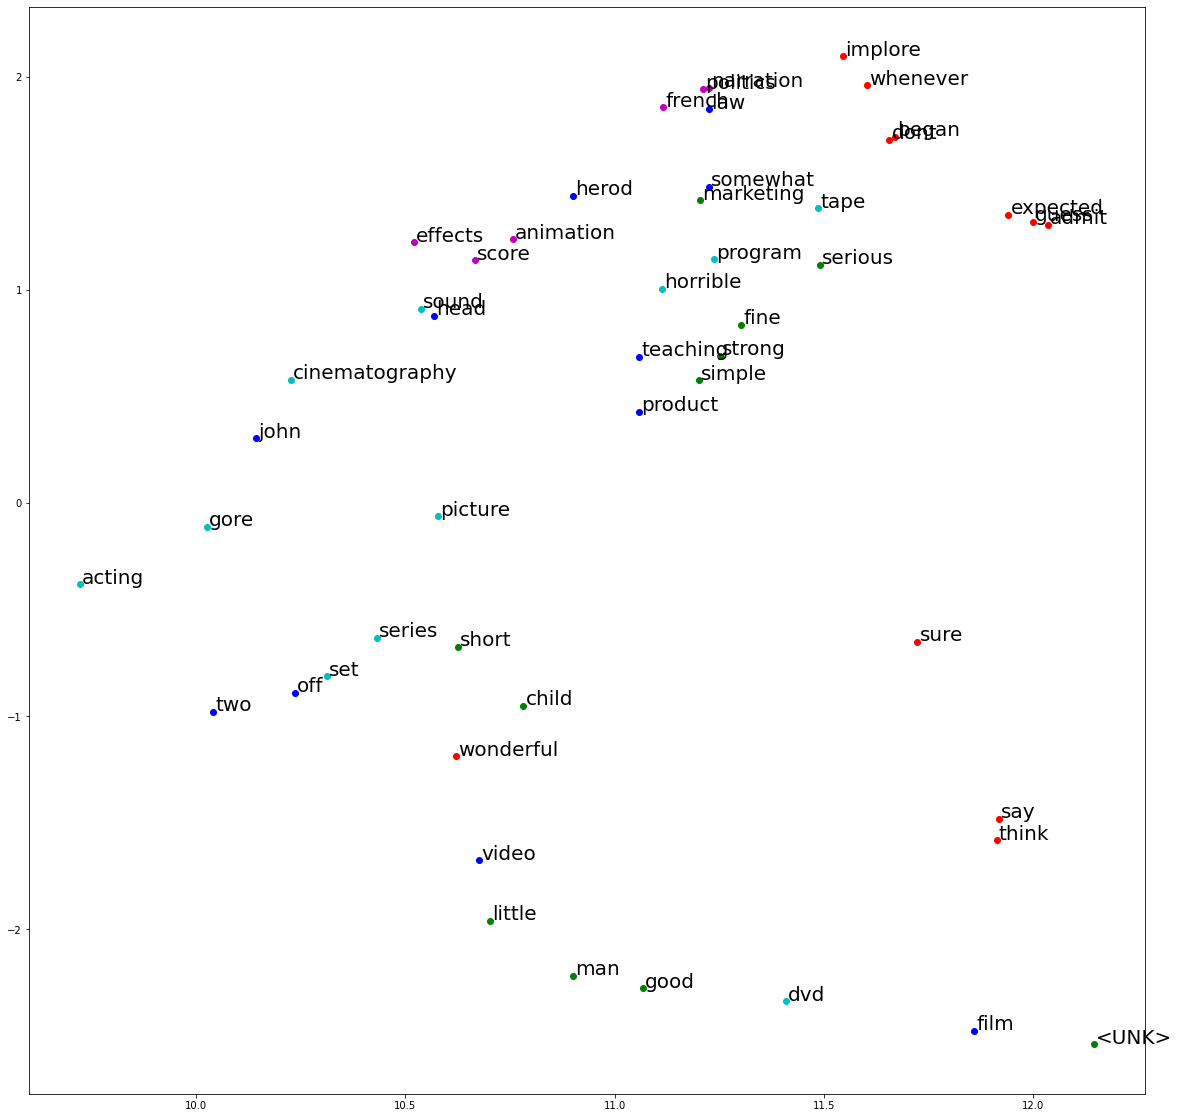

In [67]:

word_arr=['titanic','great','running','movie','music']
model=np.load("/content/drive/MyDrive/svd.npy")
plot_tsne(model,word_arr)

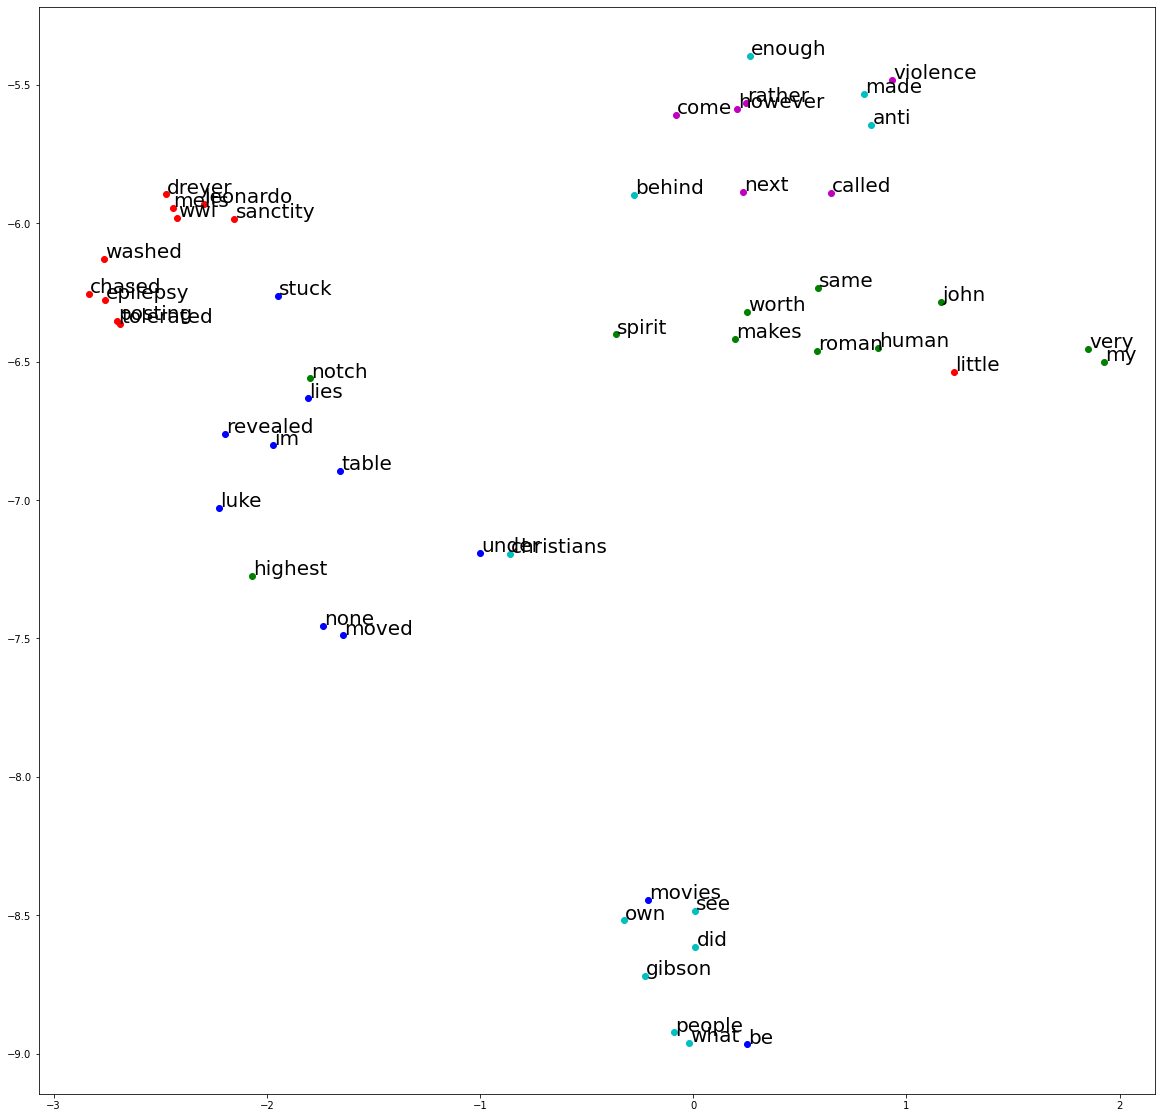

In [74]:
model=cbow_model_linear(128,1,128).to(device)
word_arr=['titanic','great','running','movie','music']
model.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/cbow_model_linear.pth", map_location=torch.device("cpu")
    )
)

plot_tsne(model,word_arr)

In [75]:
print(model)
_,x=nearest_words(model.e1.weight.data.cpu().detach().numpy(),"titanic")
print(x)

cbow_model_linear(
  (e1): Embedding(9995, 128)
  (l1): Linear(in_features=640, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
['posting', 'tolerated', 'dreyer', 'melts', 'epilepsy', 'wwi', 'chased', 'washed', 'leonardo', 'sanctity']


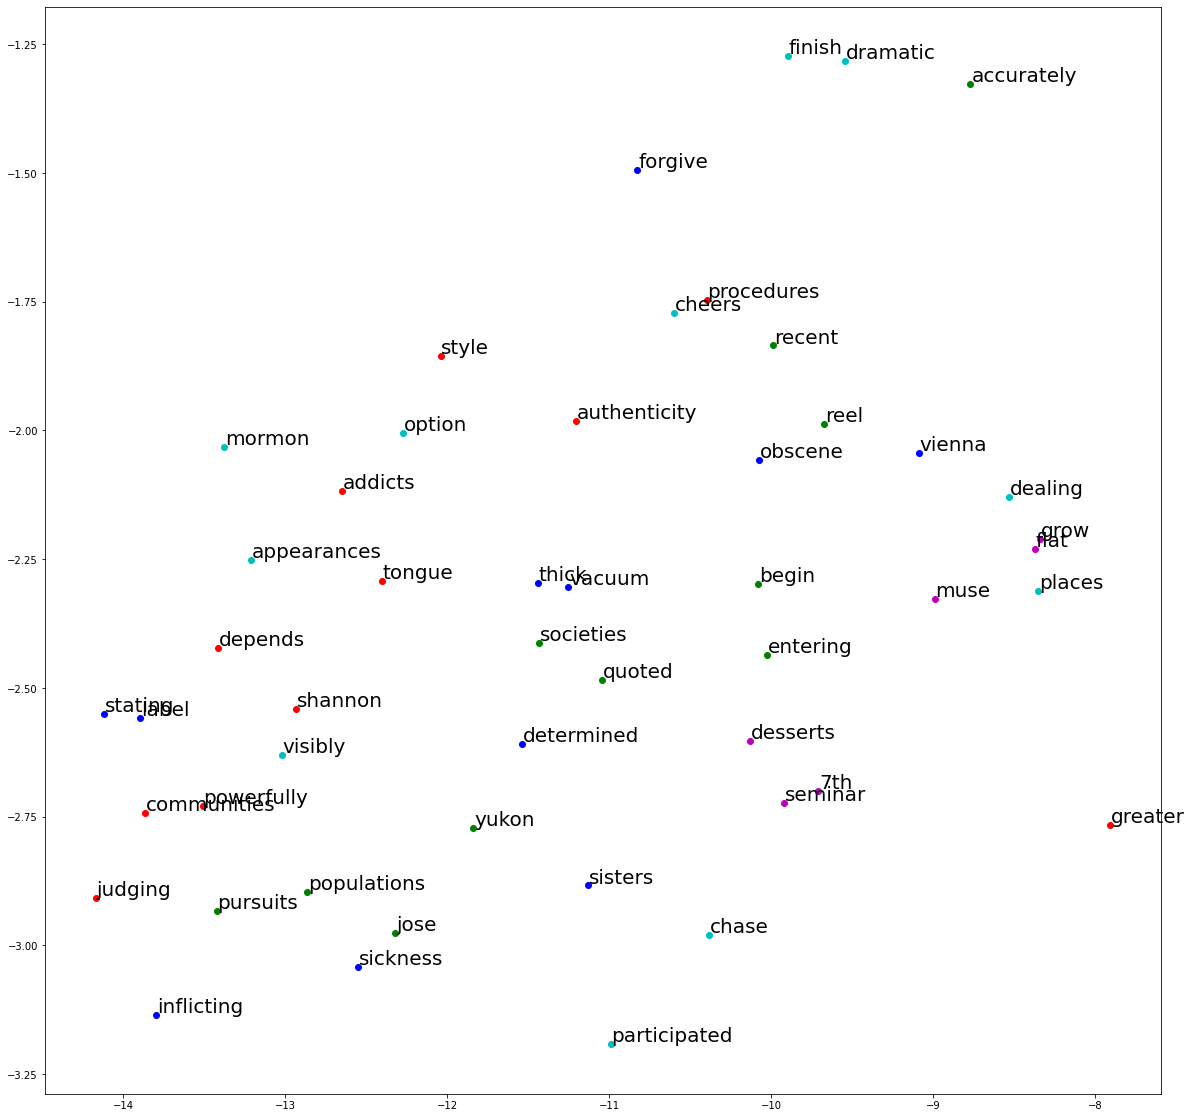

In [76]:
model=cbow_model(128,512).to(device)
word_arr=['titanic','great','running','movie','music']
model.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/working_final_all.pth", map_location=torch.device("cpu")
    )
)

plot_tsne(model,word_arr)

In [70]:
print(model)
_,x=nearest_words(model.e1.weight.data.cpu().detach().numpy(),"titanic")
print(x)

cbow_model(
  (e1): Embedding(9995, 128)
  (l1): Linear(in_features=128, out_features=512, bias=True)
  (e2): Embedding(512, 128)
)
['style', 'judging', 'depends', 'shannon', 'addicts', 'powerfully', 'procedures', 'communities', 'authenticity', 'tongue']


# Glove Embeddings

In [1]:
import gensim.downloader as api
  
def glove_embed_fn():
  
  glove_embed = api.load("word2vec-google-news-300")
  word="titanic"
  closest_words = glove_embed.most_similar(word, topn=10)
  word_arr=[]

  for word in closest_words:
    word_arr.append(word)
  return word_arr

print(glove_embed_fn())

[('epic', 0.600616455078125), ('colossal', 0.5896502137184143), ('gargantuan', 0.5718227028846741), ('titanic_proportions', 0.5610266923904419), ('titantic', 0.5592556595802307), ('monumental', 0.5530510544776917), ('monstrous', 0.5457675457000732), ('epic_proportions', 0.5437003970146179), ('gigantic', 0.5176911950111389), ('mighty', 0.5088781118392944)]
